# Customer reviews analysis using text mining - app Vinted  

### Introduction 

This project is aiming at producing comprehensive text mining analysis of customer reviews for the Vinted app, a popular online platform for second-hand fashion trading. Our focus is twofold: sentiment analysis and topic modelling, both of which offer valuable insights into customer experiences. By understanding the underlying user sentinent and common feedback themes, Vinted can make informed decisions to enhance user satisfaction, improve service quality, and maintain a competitive edge in the online marketplace. For this project, we used the dataset obtained by scrapping the Google play store. The models used for sentiment analysis and topic modelling are transformer based BERT models. 

In [2]:
# Importing necessary libraries 
import pandas as pd
import numpy as np
import warnings
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
import re as re
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
import torch

### Dataset 

For this project, we scrapped lastest 10000 customer reviews of Vinted app (french domain) from the Google Play store from 2018 to 2023, ensuring reliabe and most recent data. For the scrapping purpose, google-play-scraper library was used: https://pypi.org/project/google-play-scraper/. The following attribues are present in the dataset: reviewId, userName, userImage, content, score, thumbsUpCount, reviewCreatedVersion, replyContent, repliedAt and appVersion. For the purpose of the analysis, we used the content attribute. 


The following can be observed looking at the distribution of length of customer reviews:

* <b>Skewed Distribution:</b> The histogram illustrates a right-skewed distribution, indicating that most of the reviews are of shorter length, with the frequency decreasing as the review length increases.

* <b>Mode</b>: The mode of the review lengths appears to be in the range of 0 to 50 characters, which suggests that the majority of the reviews are very short, possibly only a few words or a sentence.

* <b>Long Reviews</b>: There are significantly fewer long reviews. The frequency decreases sharply as the length of the reviews increases beyond 50 characters, with some spikes around 500 and 1000 characters, which might indicate common lengths for more detailed feedback.

* <b>Outliers</b>: There are a few reviews that are quite lengthy, approaching 2000 characters, but these are rare when compared to the overall distribution.

* <b>Score distribution</b>: Pie chart demonstrates polarized user opinion: a majority (50.8%) rated it highly with a score of 5, while a significant minority (23.9%) gave the lowest score of 1, and fewer users rated the app in the moderate range of 2 to 4. This suggests tendency to extremes and while many users are highly satisfied, there is also notable dissatisfaction.

<b>Implications</b>: This distribution suggests that most reviews contain limited textual data, which might present challenges in extracting meaningful insights from shorter texts. The presence of longer reviews, however, can be valuable as they may contain more detailed opinions and specific feedback.

In [4]:
len(df)

10000

In [57]:
start_date = df['at'].min()
last_date = df['at'].max()

print(f"Start date: {start_date}")
print(f"Last date: {last_date}")

Start date: 2018-12-23 22:37:05
Last date: 2023-11-29 14:07:38


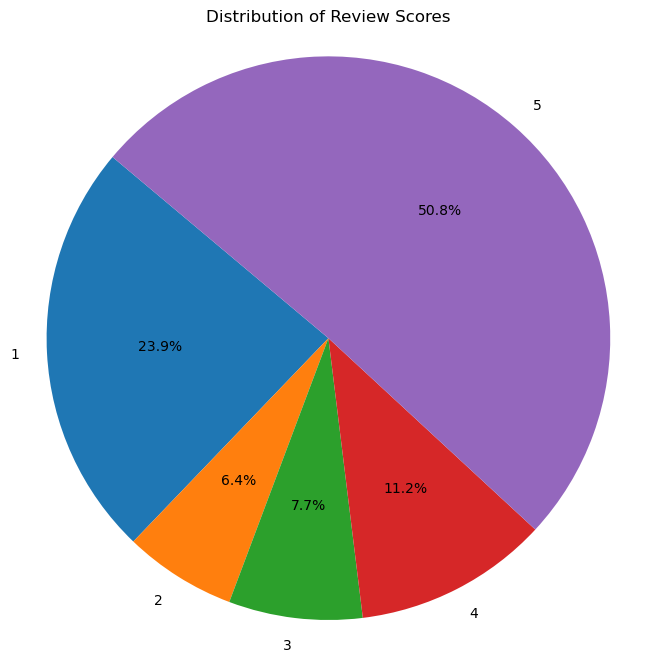

In [53]:
# Distribution of review scores
score_distribution = df['score'].value_counts().sort_index()

# Pie
plt.figure(figsize=(8, 8))
plt.pie(score_distribution, labels=score_distribution.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Review Scores')
plt.axis('equal')  
plt.show()

In [46]:
# Getting the dataset 
df = pd.read_csv('vintedreviews.csv')

df.drop(columns=['Preprocessed_review'], inplace=True)

df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,bdbbb388-8a66-475b-ae75-df2b7af2e853,Caitlyn Edwards,https://play-lh.googleusercontent.com/a-/ALV-U...,Vinted is a good selling platform because they...,3,214,23.22.1,2023-06-12 21:42:18,NaN,NaN,23.22.1
1,fbea2489-2dcf-4230-ac76-79d3bee53db6,Kenechi Obiora,https://play-lh.googleusercontent.com/a/ACg8oc...,I think the app has some really good finds at ...,4,125,23.26.0,2023-07-09 13:05:52,NaN,NaN,23.26.0
2,ef796ad5-f7d2-4767-bcda-29ffdf079508,Lyndsey Murphy,https://play-lh.googleusercontent.com/a/ACg8oc...,"Overall good app, however the interface could ...",3,8,23.45.1,2023-11-26 11:12:13,NaN,NaN,23.45.1
3,0052699a-d403-468c-a203-6e1681d4fa53,Dawn Purvis,https://play-lh.googleusercontent.com/a/ACg8oc...,I'm not going to comment on the buying and sel...,3,2,23.45.1,2023-11-27 16:03:29,NaN,NaN,23.45.1
4,957f2754-3f31-4f3e-a4ba-85ff3e6c6f7c,Jahina Begum,https://play-lh.googleusercontent.com/a/ACg8oc...,Great app for selling and buying. Easy to use....,3,4,23.45.1,2023-11-25 14:51:26,NaN,NaN,23.45.1


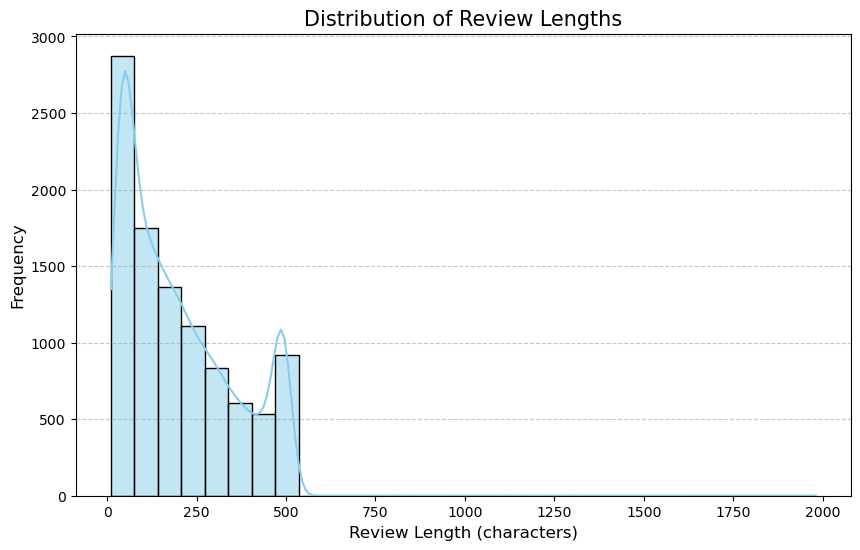

In [11]:
# Calculate the length of each review
df['review_length'] = df['content'].apply(len)

# Plot
plt.figure(figsize=(10, 6))
sns.histplot(df['review_length'], bins=30, kde=True, color='skyblue')

plt.title('Distribution of Review Lengths', fontsize=15)
plt.xlabel('Review Length (characters)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Method / Model 

<b>Topic Modelling with BERTopic</b>

To identify common customer feedback themes, we utilized pre-trained BERTopic, an advanced topic modelling technique utilizing the Bidirectional Encoder Representations from Transformers (BERT) architecture, known for its state-of-the-art performance in NLP tasks. 

BERTopic idenifies patterns in text data, making it particularly suitable for analyzing customer reviews. This model generates topics by clustering similar document representations that are obtained after transforming the reviews into embeddings using BERT. Some of the strengths of this model is analyzing text in context, and ability to dynamically reduce or increase the number of topics based on the coherence scores, however for the purpose of this project, we constrained the model to identify 30 distinct topics to maintain interpretability of the result. 

The n_gram_range parameter was set to (2,3) focusing the model to consider bi-grams, and tri-grams, which are consequtive words. This decision was informed by the nature of the dataset; customer reviews often contain significant bi-grams and tri-grams that can represent specific attributes (e.g., "poor customer service", "shipping time") more effectively than single words, thus enhancing the topic quality and relevance.

<b>Sentiment Analysis with BERT</b>

After topic modelling, we employed a pre-trained BERT-based sentiment analysis model to determine the sentiment of each identified topic. This model is fine-tuned to classify sentiments as positive, neutral, or negative, allowing us to understand the emotional tone associated with each topic. 

We used 'distilbert-base-uncased-finetuned-sst-2-english' model from Hugging Face. It is an optimal choice because it's a fine-tuned version of DistilBERT specifically trained for English text sentiment classification on the SST-2 dataset. It offers efficiency, as it's a smaller and faster variant of BERT while still performing reasonably well.

### Text pre-processing 

It is suggested that for BERT-based models text pre-prpocessing is not required, and even not recommended. BERT-based models are designed to process natural language text and understand the context of entire sentences. They utilize a WordPiece tokenization mechanism, allowing BERT to represent words as a combination of subword tokens. This helps to handle the textual data without the need for traditional preprocessing steps like stemming or stopword and punctuation removal. These models learn from context within the text, therefore they benefit from the full, unaltered text data. Preprocessing that simplifies or alters the text can actually reduce the models' ability to accurately capture sentiments and topics as it would strip away the very context they rely on for understanding the text.

In [ ]:
### NOT REQUIRED 

# Prepare text for sentiment analysis
# def text_preprocessing(text,additional_stopwords=set()):
    
#     # Convert text to lowercase
#     text = text.lower()

#     text = re.sub(r'[^a-zA-Z\s]', '', text)
    
#     # Tokenize text
#     tokens = word_tokenize(text)

#     # Get standard stopwords
#     standard_stopwords = set(stopwords.words('english'))

#     # Combine standard stopwords with custom ones
#     all_stopwords = standard_stopwords.union(additional_stopwords)

#     # Remove stopwords
#     cleaned_tokens = [token for token in tokens if token not in all_stopwords]

#     # Joining the tokens back into a string
#     return ' '.join(cleaned_tokens)


# Additional stopwords
# additional_stopwords = {"vinted", "app"}


# df['Preprocessed_review'] = df['content'].apply(lambda x: text_preprocessing(x, additional_stopwords))
# df.head(1)

### BERT Topic - model for topic modelling

In [12]:
# Set seeds for numpy and torch 
np.random.seed(42)
if torch.cuda.is_available():
    torch.manual_seed(42)
    torch.cuda.manual_seed_all(42)


#Topic modelling with BERT
topic_model = BERTopic(verbose=True, nr_topics=30, n_gram_range=(2,3))

topics, probabilities = topic_model.fit_transform(df['content'])

2024-02-01 23:07:08,417 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

2024-02-01 23:07:46,317 - BERTopic - Embedding - Completed ✓
2024-02-01 23:07:46,318 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-02-01 23:07:50,852 - BERTopic - Dimensionality - Completed ✓
2024-02-01 23:07:50,853 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-02-01 23:07:51,013 - BERTopic - Cluster - Completed ✓
2024-02-01 23:07:51,014 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-02-01 23:07:52,341 - BERTopic - Representation - Completed ✓
2024-02-01 23:07:52,343 - BERTopic - Topic reduction - Reducing number of topics
2024-02-01 23:07:53,568 - BERTopic - Topic reduction - Reduced number of topics from 115 to 30


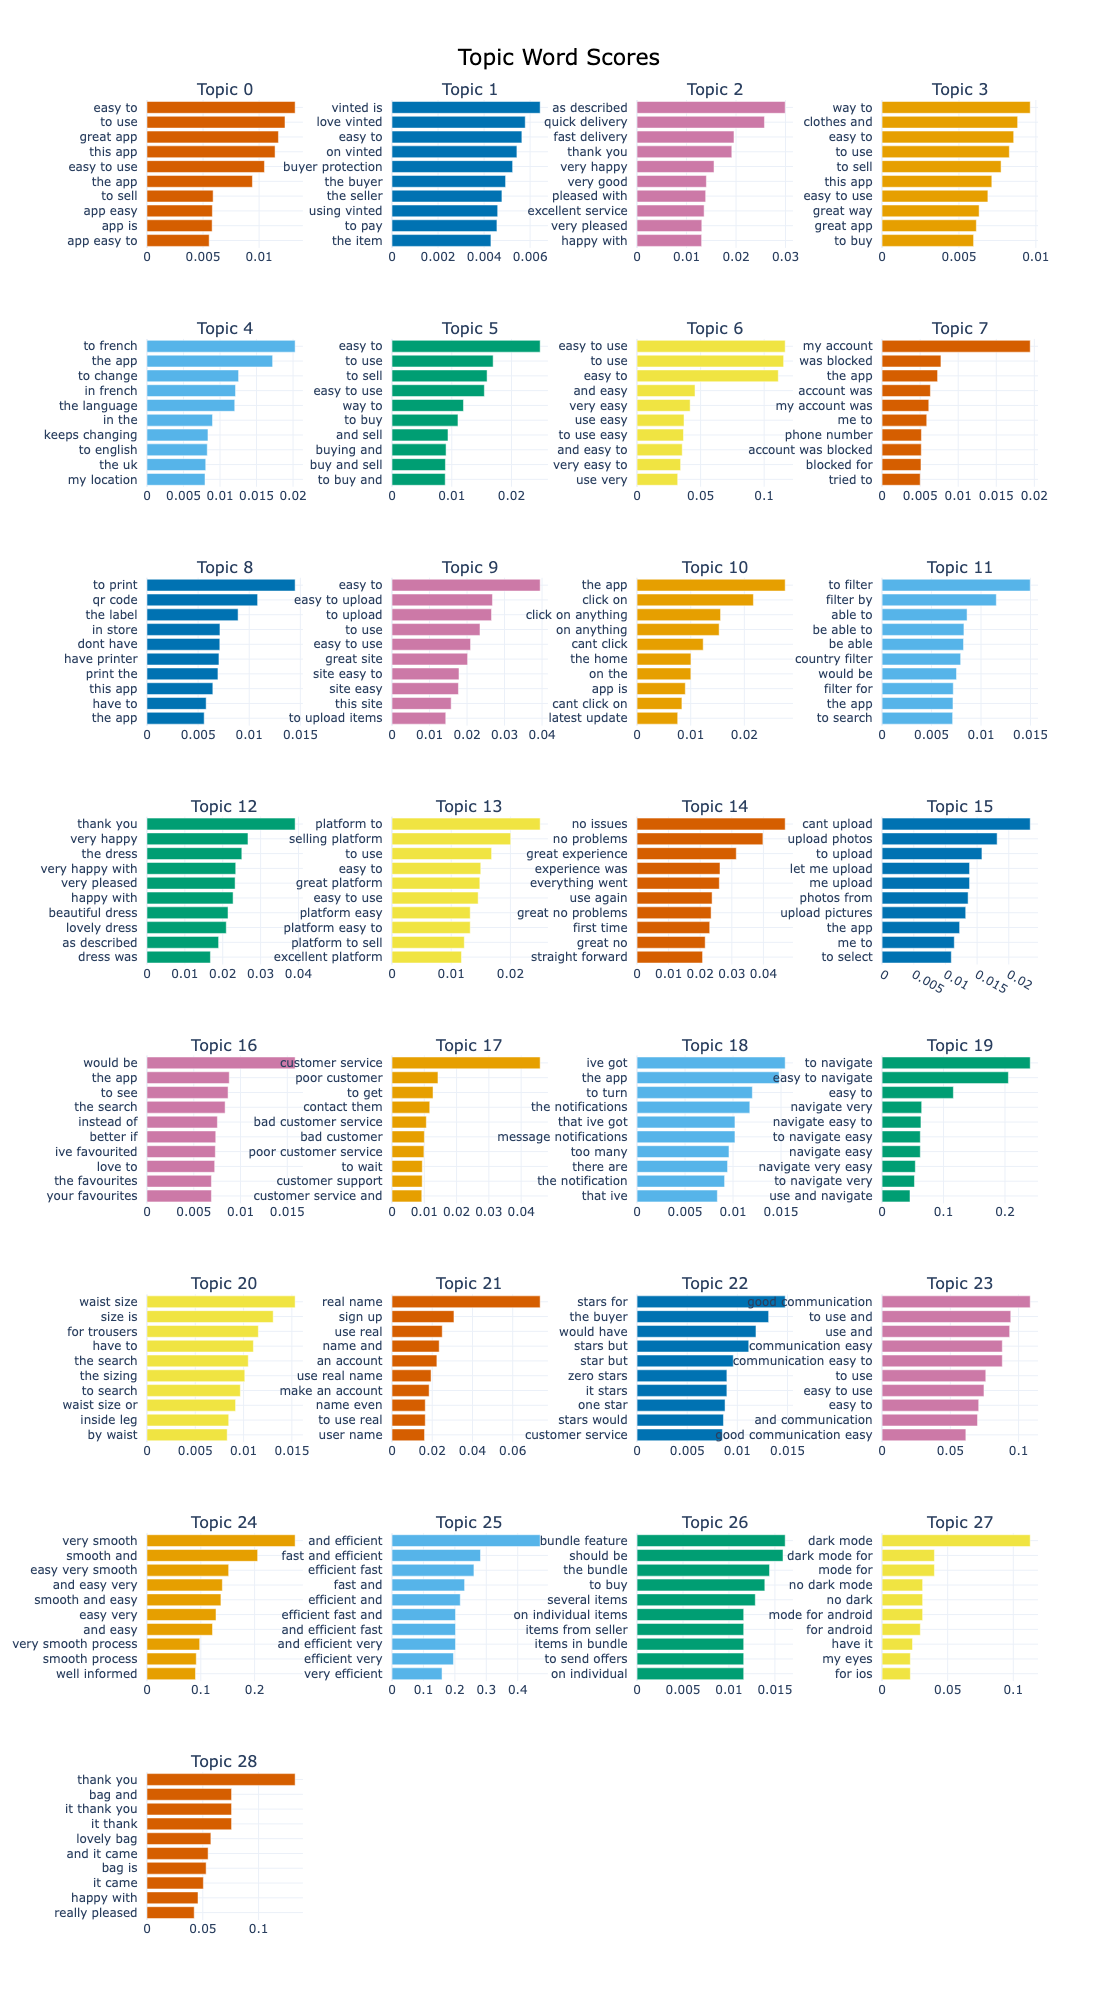

In [16]:
# Visualize the top words for each topic
topic_model.visualize_barchart(top_n_topics=30, n_words=10)

### DistilBERT light - model for sentiment analysis per topic 

In [17]:
# Sentiment analysis pipeline
sentiment_pipeline = pipeline('sentiment-analysis', model='distilbert-base-uncased-finetuned-sst-2-english')

In [18]:
# Get sentiment for each review
def get_bert_sentiment(text):
    result = sentiment_pipeline(text)[0]
    return result['label']

df['BERT_sentiment'] = df['content'].apply(get_bert_sentiment)

### Examining proposed topics vs review content and scores 

In [28]:
# Get the topic info with names 
topic_info = topic_model.get_topic_info()

# Create a dictionary mapping topic numbers to names
topic_names = {row['Topic']: row['Name'] for index, row in topic_info.iterrows()}

# Assign the topic names 
df['topic_name'] = [topic_names[topic] for topic in topics]


df.tail()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,Preprocessed_review,topic,BERT_sentiment,topic_number,topic_name
9995,de714ca2-1580-49ce-a9a2-70edb376cdd9,Shelley Bethel,https://play-lh.googleusercontent.com/a/ACg8oc...,Quick and easy even for me 😊 Thank you,5,0,23.33.2,2023-09-04 16:05:44,NaN,NaN,23.33.2,quick even thank,6,POSITIVE,6,6_easy to use_to use_easy to_and easy
9996,87ce8664-9161-49d4-8ecd-fb5542887743,lisa binaghi,https://play-lh.googleusercontent.com/a/ACg8oc...,Well curated and helps with the eco friendly f...,5,0,23.26.0,2023-09-06 16:54:19,NaN,NaN,23.26.0,well curated helps eco friendly fashion market,3,POSITIVE,3,3_way to_clothes and_easy to_to use
9997,92522152-38b2-4016-bd8b-507cf678c699,Irene Himsworth,https://play-lh.googleusercontent.com/a/ACg8oc...,"All good, both selling and buying.",5,0,23.31.0,2023-09-02 14:20:21,NaN,NaN,23.31.0,selling buying,-1,POSITIVE,-1,-1_the app_easy to_to use_this app
9998,a86f8061-6d4a-4726-a59f-6c643e8fc015,Ollie. T,https://play-lh.googleusercontent.com/a/ACg8oc...,Blocked my account even though it hadn't been ...,1,1,23.33.2,2023-09-03 13:38:56,NaN,NaN,23.33.2,blocked account even though hadnt used yet won...,7,NEGATIVE,7,7_my account_was blocked_the app_account was
9999,a40eddcd-5bbe-4299-8497-16505529fe10,Dalila Corda,https://play-lh.googleusercontent.com/a/ACg8oc...,"Excellent, so easy to use.",5,0,23.33.2,2023-09-07 14:38:20,NaN,NaN,23.33.2,excellent,6,POSITIVE,6,6_easy to use_to use_easy to_and easy


### Assignment of sentiments to each topic 

In [32]:
# Groupby topic number and name and find the most frequent sentiment
dominant_sentiment_per_topic = df.groupby(['topic', 'topic_name'])['BERT_sentiment'].agg(lambda x: pd.Series.mode(x)[0])

# Show the dominant sentiment for each topic
dominant_sentiment_per_topic)

topic  topic_name                                                 
-1     -1_the app_easy to_to use_this app                             NEGATIVE
 0     0_easy to_to use_great app_this app                            POSITIVE
 1     1_vinted is_love vinted_easy to_on vinted                      POSITIVE
 2     2_as described_quick delivery_fast delivery_thank you          POSITIVE
 3     3_way to_clothes and_easy to_to use                            POSITIVE
 4     4_to french_the app_to change_in french                        NEGATIVE
 5     5_easy to_to use_to sell_easy to use                           POSITIVE
 6     6_easy to use_to use_easy to_and easy                          POSITIVE
 7     7_my account_was blocked_the app_account was                   NEGATIVE
 8     8_to print_qr code_the label_in store                          NEGATIVE
 9     9_easy to_easy to upload_to upload_to use                      POSITIVE
 10    10_the app_click on_click on anything_on anything        

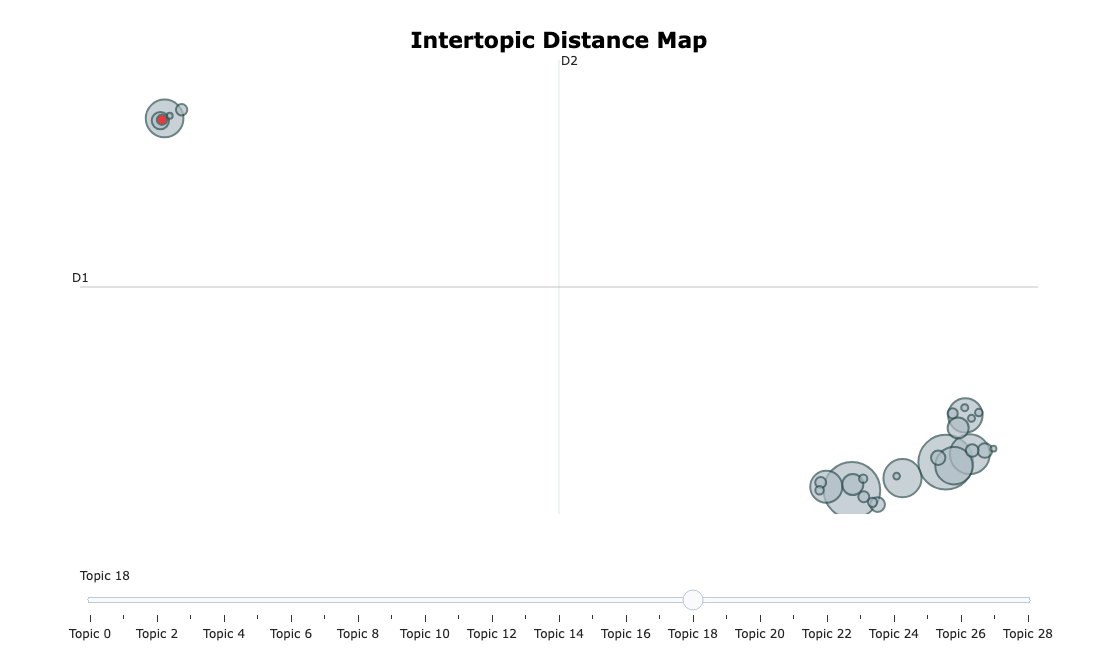

In [36]:
topic_model.visualize_topics()

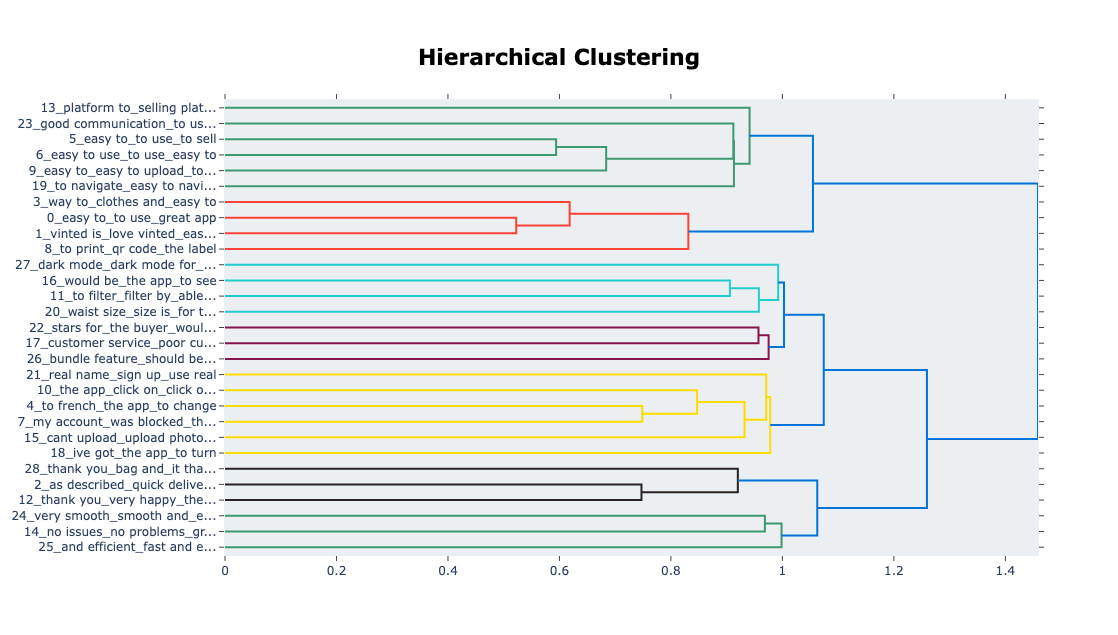

In [37]:
topic_model.visualize_hierarchy(top_n_topics=30)

### Results 

We utilized BERT transformed models to identify 30 most common feedback themes and respective sentiments among Vinted customers. Combining identified topics with the most common sentiment for the topic was praticularity useful as sometimes topic modelling output can suggest that certain app features are being discussed, however it is not always clear if users are satisfied with it or not. Based on the model results and analysis, common user feedback was ineterpeted as follows: 

Topic -1: Noise topic containing irrelevant text, such as stopwords.

Topic 0: Positive feedback focusing on the ease of use and the great experience of using the app.

Topic 1: Positive sentiment expressing love for Vinted and finding it easy to use.

Topic 2: Satisfaction with fast delivery.

Topic 3: Satisfaction with ease of buying and selling clothes on the app.

Topic 4: Issues with language and translations (english-french). 

Topic 5: Satisfaction with the ease of use and selling items on the app.

Topic 6: Satisfaction with aap's ease of use.

Topic 7: Concerns regarding account issues and blocked accounts.

Topic 8: Issues with printing QR codes and labels in stores.

Topic 9: Satisfaction with the ease of uploading and using the app.

Topic 10: Issues with clicking on items or links within the app.

Topic 11: Focusing on issues with the filtering feature.

Topic 12: Positive feedback expressing thanks and happiness with the dresses and the overall experience with the app.

Topic 13: Positive feedback discussing the selling platform and its ease of use.

Topic 14: Positive feedback suggesting no significant issues and reflecting a great experience.

Topic 15: Highlighting problems with the feature of uploading photos.

Topic 16: Expressing a desire to see improvements in the app's search and filter functionality.

Topic 17: Discussing poor customer service and the difficulty in contacting them.

Topic 18: Mentioning issues with turning off app notifications (distrubing). 

Topic 19: Positive feedback praising the ease of navigation within the app.

Topic 20: Mentioning the absence of a waist size attribute for trousers.

Topic 21: Concerns about using real names and indicating privacy or security issues.

Topic 22: Dissatisfaction with the review (stars) system for buyers within the app.

Topic 23: Positive feedback emphasizing good communication and ease of use.

Topic 24: Satisfaction with smoothness and efficiency of the app, possibly regarding performance.

Topic 25: Highlighting fast and efficient delivery.

Topic 26: Suggesting the need to introduce a bundle feature.

Topic 27: Negative feedback expressing complaints about the lack of a dark mode feature.

Topic 28: Overall positive feedback, particularly regarding bags and items.


<b>What is going well?</b>

Vinted's user feedback reveals several positive aspects that contribute to customer satisfaction, highlighting elements of ease of use, smoothness, efficient delivery, and overall satisfaction with the platform. Users appreciate the app's stability, easy navigation and quick delivery. The positive feedback on communication and user engagement is also encouraging. To further enhance customer satisfaction, Vinted should continue to prioritize these aspects, ensuring a seamless and enjoyable experience for its users.

<b>What can be improved?</b>

However, Vinted also faces several challenges based on user feedback. Users point out issues related language translations, account blocking, customer service, distrubing app notifications, missing attributes, issues with filters, privacy concerns, and problems with the review system of buyers. It's crucial for Vinted team to address these negative aspects promptly. Implementing solutions to address these concerns will go a long way in improving customer satisfaction. Additionally, considering features like dark mode and a bundle feature as suggested in Topics 26 and 27 can enhance user experience further. Vinted should actively work on these action points to provide a more user-friendly and reliable platform for its customers.

### Conclusion 

In conclusion, our project successfully employed text mining techniques to analyze customer reviews of the Vinted app. Our main goals were to perform sentiment analysis and topic modeling to gain valuable insights into customer experiences and feedback. We obtained a dataset comprising 10,000 customer reviews from the Google Play store, ensuring the reliability and recency of the data. After preprocessing, we used advanced models, including BERTopic for topic modeling and a fine-tuned DistilBERT model for sentiment analysis. The results of our analysis revealed a wide range of topics and sentiments expressed by Vinted users. Customers expressed positive sentiments, particularly praising the app's ease of use, great experiences,love for Vinted as well as quick delivery, smooth transactions, and good communication. Negative feedback covered various issues, including language and translation problems, account-related concerns, app functionality / features issues, and customer service complaints. Our project provides Vinted with actionable insights for improving user satisfaction and addressing specific issues highlighted by customers.

### Improvement

As part of this project, we were able to identify and clearly distiguish common user feedback for the Vinted app. At the same time, there are few ideas worth exploration to improve this project:

* Utilizing the date and app version attribute in the analysis to identify feedback evolution over time or/and identify user feedback for a particular app update
* Creating scalable solution/app for analyzing reviews from google-play-store for any app

 ### References 

1. https://www.researchgate.net/publication/361640948_On_the_Role_of_Text_Preprocessing_in_BERT_Embedding-based_DNNs_for_Classifying_Informal_Texts